# Relate zonal SST gradient to changes in ENSO variance


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 13}
mpl.rc('font', **font)

import numpy as np
# from scipy.io import netcdf
# import scipy.stats as stats
import pandas as pd

import xarray as xr
# import random
import os
from pprint import pprint
from tqdm import tqdm
import cftime

## Basic information for reading in data

In [2]:
# directory for saving plots
plotdir = '/glade/scratch/samantha/plots/ENSOworkshop/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
    
basedir_processed_MMLEA = '/glade/work/sasanch/ENSOworkshop/'

# Periods to use for calculating differences
st_int=[1951,1980]
#end_int=[2070,2099]
end_int=[2021,2050]

#st_int=[1950,2005]
#end_int=[2006,2100]
windlen=360

### Read in time series and SST fields

In [3]:
# List models
models = [f for f in os.listdir(basedir_processed_MMLEA) if not f.startswith(('.','model_variants','native_grid','unsorted','nino')) and not '.pdf' in f]
mods=sorted(models)
print(mods)

['access_lens', 'canesm2_lens', 'canesm5_lens', 'cesm1_lens', 'cesm2_lens', 'csiro_mk36_lens', 'ec-earth3_lens', 'gfdl_cm3_lens', 'gfdl_esm2m_v2_lens', 'gfdl_spear_lens', 'ipsl_cm6a_lens', 'miroc6_lens', 'miroc_esm2l_lens', 'mpi_lens']


There are quite a few models now available! Specifying upper-case model names manually:

In [4]:
modscaps=['ACCESS','CanESM2','CanESM5','CESM1','CESM2','CSIRO-Mk3.6','EC-Earth','GFDL-CM3','GFDL-ESM2M','GFDL-SPEAR','IPSL-CM6A','MIROC6','MIROC-ESM2L','MPI']

#mods=['cesm1_lens','gfdl_esm2m_v2_lens']
#modscaps=['CESM1','GFDL-ESM2M']


Now doing the actual reading in of the data!

In [5]:
ens_n34std_arr=[]
ens_zdiff_arr=[]

for m in tqdm(range(len(mods))):  
    print(mods[m])
    epsst=[]
    wpsst=[]
    n34sst=[]    

    if not "access" in mods[m]:
        # directories with processed output
        basedir_processed_MMLEA = '/glade/work/sasanch/ENSOworkshop/'
    else:
        basedir_processed_MMLEA = '/glade/campaign/cgd/cas/nmaher/'
    
    if not "gfdl_cm3" in mods[m]:
        moddir=basedir_processed_MMLEA+mods[m]+'/Omon/tos/'
        moddirssp=moddir
        f=os.listdir(basedir_processed_MMLEA+mods[m]+'/Omon/tos/')
        hfiles=[h for h in f if "historical" in h]
        
        if "cesm2" in mods[m]:
            hfiles=[h for h in f if "BHIST" in h]
    else:
        moddir=basedir_processed_MMLEA+mods[m]+'/Amon/ts/'
        moddirssp=moddir
        f=os.listdir(basedir_processed_MMLEA+mods[m]+'/Amon/ts/')
        hfiles=[h for h in f if "historical" in h]
            
    #print(hfiles)
    
    for hf in hfiles:
        # Determine whether to include this member based on whether it has both a historical and an SSP portion                     
        txt=hf.split("_")
        if (("historical" in txt) and ("rcp85" in txt)) or (("historical" in txt) and ("ssp370" in txt or "ssp585" in txt or "SSP585" in txt or "SSP370" in txt)):
            mem=txt[5]
        elif "cesm2" in mods[m]:
            txt=hf.split(".")
            mem=txt[4]+'.'+txt[5]
        else:
            mem=txt[4] 
                    
        if ("canesm5" in mods[m]) or ("access" in mods[m]) or ("ipsl" in mods[m]):
            hfut=[h for h in f if mem in h and "ssp370" in h]    
        elif "cesm2" in mods[m]:
            hfut=[h for h in f if mem in h and "SSP370" in h]
        else:
            hfut=[h for h in f if mem in h and ("ssp585" in h or "rcp85" in h or "SSP585" in h)]    
                
        if hfut:
            hfssp=hfut[0]
            
            # READ IN HISTORICAL DATA
            if not "gfdl_cm3" in mods[m]:
                mytos=xr.open_dataset(moddir+hf).tos.squeeze()
            else:
                mytos=xr.open_dataset(moddir+hf).ts.squeeze()

            # Eastern Pacific
            mask_lon = (mytos.lon >= 210) & (mytos.lon <= 270)
            mask_lat = (mytos.lat >= -5) & (mytos.lat <= 5)
            hep=mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze()
                            
            # Western Pacific
            mask_lon = (mytos.lon >= 120) & (mytos.lon <= 180)
            hwp=mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze()
        
            # NINO3 
            mask_lon = (mytos.lon >= 210) & (mytos.lon <= 270)
            mask_lat = (mytos.lat >= -5) & (mytos.lat <= 5)
            hn34=mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze()

            if not hfssp == hf:
                # READ IN SSP DATA
                if not "gfdl_cm3" in mods[m]:
                    mytos=xr.open_dataset(moddirssp+hfssp).tos.squeeze()
                else:
                    mytos=xr.open_dataset(moddirssp+hfssp).ts.squeeze()

                # Eastern Pacific
                mask_lon = (mytos.lon >= 210) & (mytos.lon <= 270)
                mask_lat = (mytos.lat >= -5) & (mytos.lat <= 5)
                sspep=mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze()
        
                # Western Pacific
                mask_lon = (mytos.lon >= 120) & (mytos.lon <= 180)
                sspwp=mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze()
        
                # NINO3.4 
                mask_lon = (mytos.lon >= 190) & (mytos.lon <= 240)
                mask_lat = (mytos.lat >= -5) & (mytos.lat <= 5)
                sspn34=mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze()
            
                hep=xr.concat([hep,sspep],dim="time")
                hwp=xr.concat([hwp,sspwp],dim="time")
                hn34=xr.concat([hn34,sspn34],dim="time")
        
            epsst.append(hep)
            wpsst.append(hwp)
            n34sst.append(hn34)
            
    if len(epsst) > 0:    
        # Make xarray DataArrays if data actually exists
        ens_ep=xr.concat(epsst,dim='member')
        ens_wp=xr.concat(wpsst,dim='member')
        ens_n34=xr.concat(n34sst,dim='member')
    
        # Remove ensemble mean from NINO3.4, to allow computation of variance
        ens_n34=ens_n34-ens_n34.mean('member')
        
        # Calculate differences from the reference period     
        tmpn34std=np.zeros((len(hep)))
        tmpzdiff=np.zeros((len(hep)))
        
        # Convert calendars
        if "cesm" in mods[m] or "canesm" in mods[m] or "gfdl" in mods[m] and not "gfdl_spear" in mods[m]:
            resampled = ens_n34.resample(time="MS").mean()
            ens_n34['time'] = resampled.indexes["time"].to_datetimeindex()
            resampled = ens_ep.resample(time="MS").mean()
            ens_ep['time']=resampled.indexes['time'].to_datetimeindex()
            resampled = ens_wp.resample(time="MS").mean()
            ens_wp['time']=resampled.indexes['time'].to_datetimeindex()
            
        # Subtract rolling 30-year climatology from NINO3.4 to get NINO3.4 SSTA
        ens_n34tmp=ens_n34
        for t in range(len(ens_n34tmp.time)-windlen):
            if t <= len(ens_n34tmp.time)-windlen:
                clim=ens_n34tmp[:,t:(t+windlen)].groupby('time.month').mean()
                ens_n34[:,t:(t+windlen)]=ens_n34tmp[:,t:(t+windlen)].groupby('time.month')-clim
            else:
                clim=ens_n34tmp[:,len(ens_n34tmp.time)-windlen,len(ens_n34tmp.time)-1].groupby('time.month').mean()
                ens_n34[:,t:(t+windlen)]=ens_n34tmp[:,t:(t+windlen)].groupby('time.month')-clim
        
        # Take DJF mean
        tmpdjf=ens_n34.resample(time='QS-DEC').mean(dim="time")
        tmpdjf=tmpdjf.where(tmpdjf.time.dt.month == 12,drop="True")
        ens_n34_djf=tmpdjf[:,1:]
        
        tmpdjf=ens_ep.resample(time='QS-DEC').mean(dim="time")
        tmpdjf=tmpdjf.where(tmpdjf.time.dt.month == 12,drop="True")
        ens_ep_djf=tmpdjf[:,1:]
        
        tmpdjf=ens_wp.resample(time='QS-DEC').mean(dim="time")
        tmpdjf=tmpdjf.where(tmpdjf.time.dt.month == 12,drop="True")
        ens_wp_djf=tmpdjf[:,1:]
        
        # Calculate changes in NINO3.4 standard deviation, zonal SST gradient
        tmpn34std=ens_n34_djf.sel(time=slice(str(end_int[0])+'-01-01',str(end_int[1])+'-12-31')).std('time').squeeze() - ens_n34_djf.sel(time=slice(str(st_int[0])+'-01-01',str(st_int[1])+'-12-31')).std('time').squeeze() 
        tmp_zdiff_early=ens_ep_djf.sel(time=slice(str(st_int[0])+'-01-01',str(st_int[1])+'-12-31')).mean('time').squeeze() - ens_wp_djf.sel(time=slice(str(st_int[0])+'-01-01',str(st_int[1])+'-12-31')).mean('time').squeeze()
        tmp_zdiff_late=ens_ep_djf.sel(time=slice(str(end_int[0])+'-01-01',str(end_int[1])+'-12-31')).mean('time').squeeze() - ens_wp_djf.sel(time=slice(str(end_int[0])+'-01-01',str(end_int[1])+'-12-31')).mean('time').squeeze()
        
        ens_n34std_arr.append(tmpn34std)
        ens_zdiff_arr.append(tmp_zdiff_late - tmp_zdiff_early)
    

  0%|          | 0/14 [00:00<?, ?it/s]

access_lens


  7%|▋         | 1/14 [01:26<18:42, 86.36s/it]

canesm2_lens


/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle error

canesm5_lens


/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle error

cesm1_lens


/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle error

cesm2_lens


/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle error

csiro_mk36_lens


 43%|████▎     | 6/14 [08:05<11:24, 85.59s/it]

ec-earth3_lens


 50%|█████     | 7/14 [09:37<10:12, 87.53s/it]

gfdl_cm3_lens


/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle error

gfdl_esm2m_v2_lens


/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/samantha/npl_clone_16sep2021/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle error

gfdl_spear_lens


 71%|███████▏  | 10/14 [12:26<04:28, 67.03s/it]

ipsl_cm6a_lens


 79%|███████▊  | 11/14 [13:25<03:14, 64.86s/it]

miroc6_lens


 86%|████████▌ | 12/14 [15:02<02:28, 74.40s/it]

miroc_esm2l_lens


 93%|█████████▎| 13/14 [16:01<01:09, 69.75s/it]

mpi_lens


100%|██████████| 14/14 [17:52<00:00, 76.64s/it]


Now go through and plot the results!!

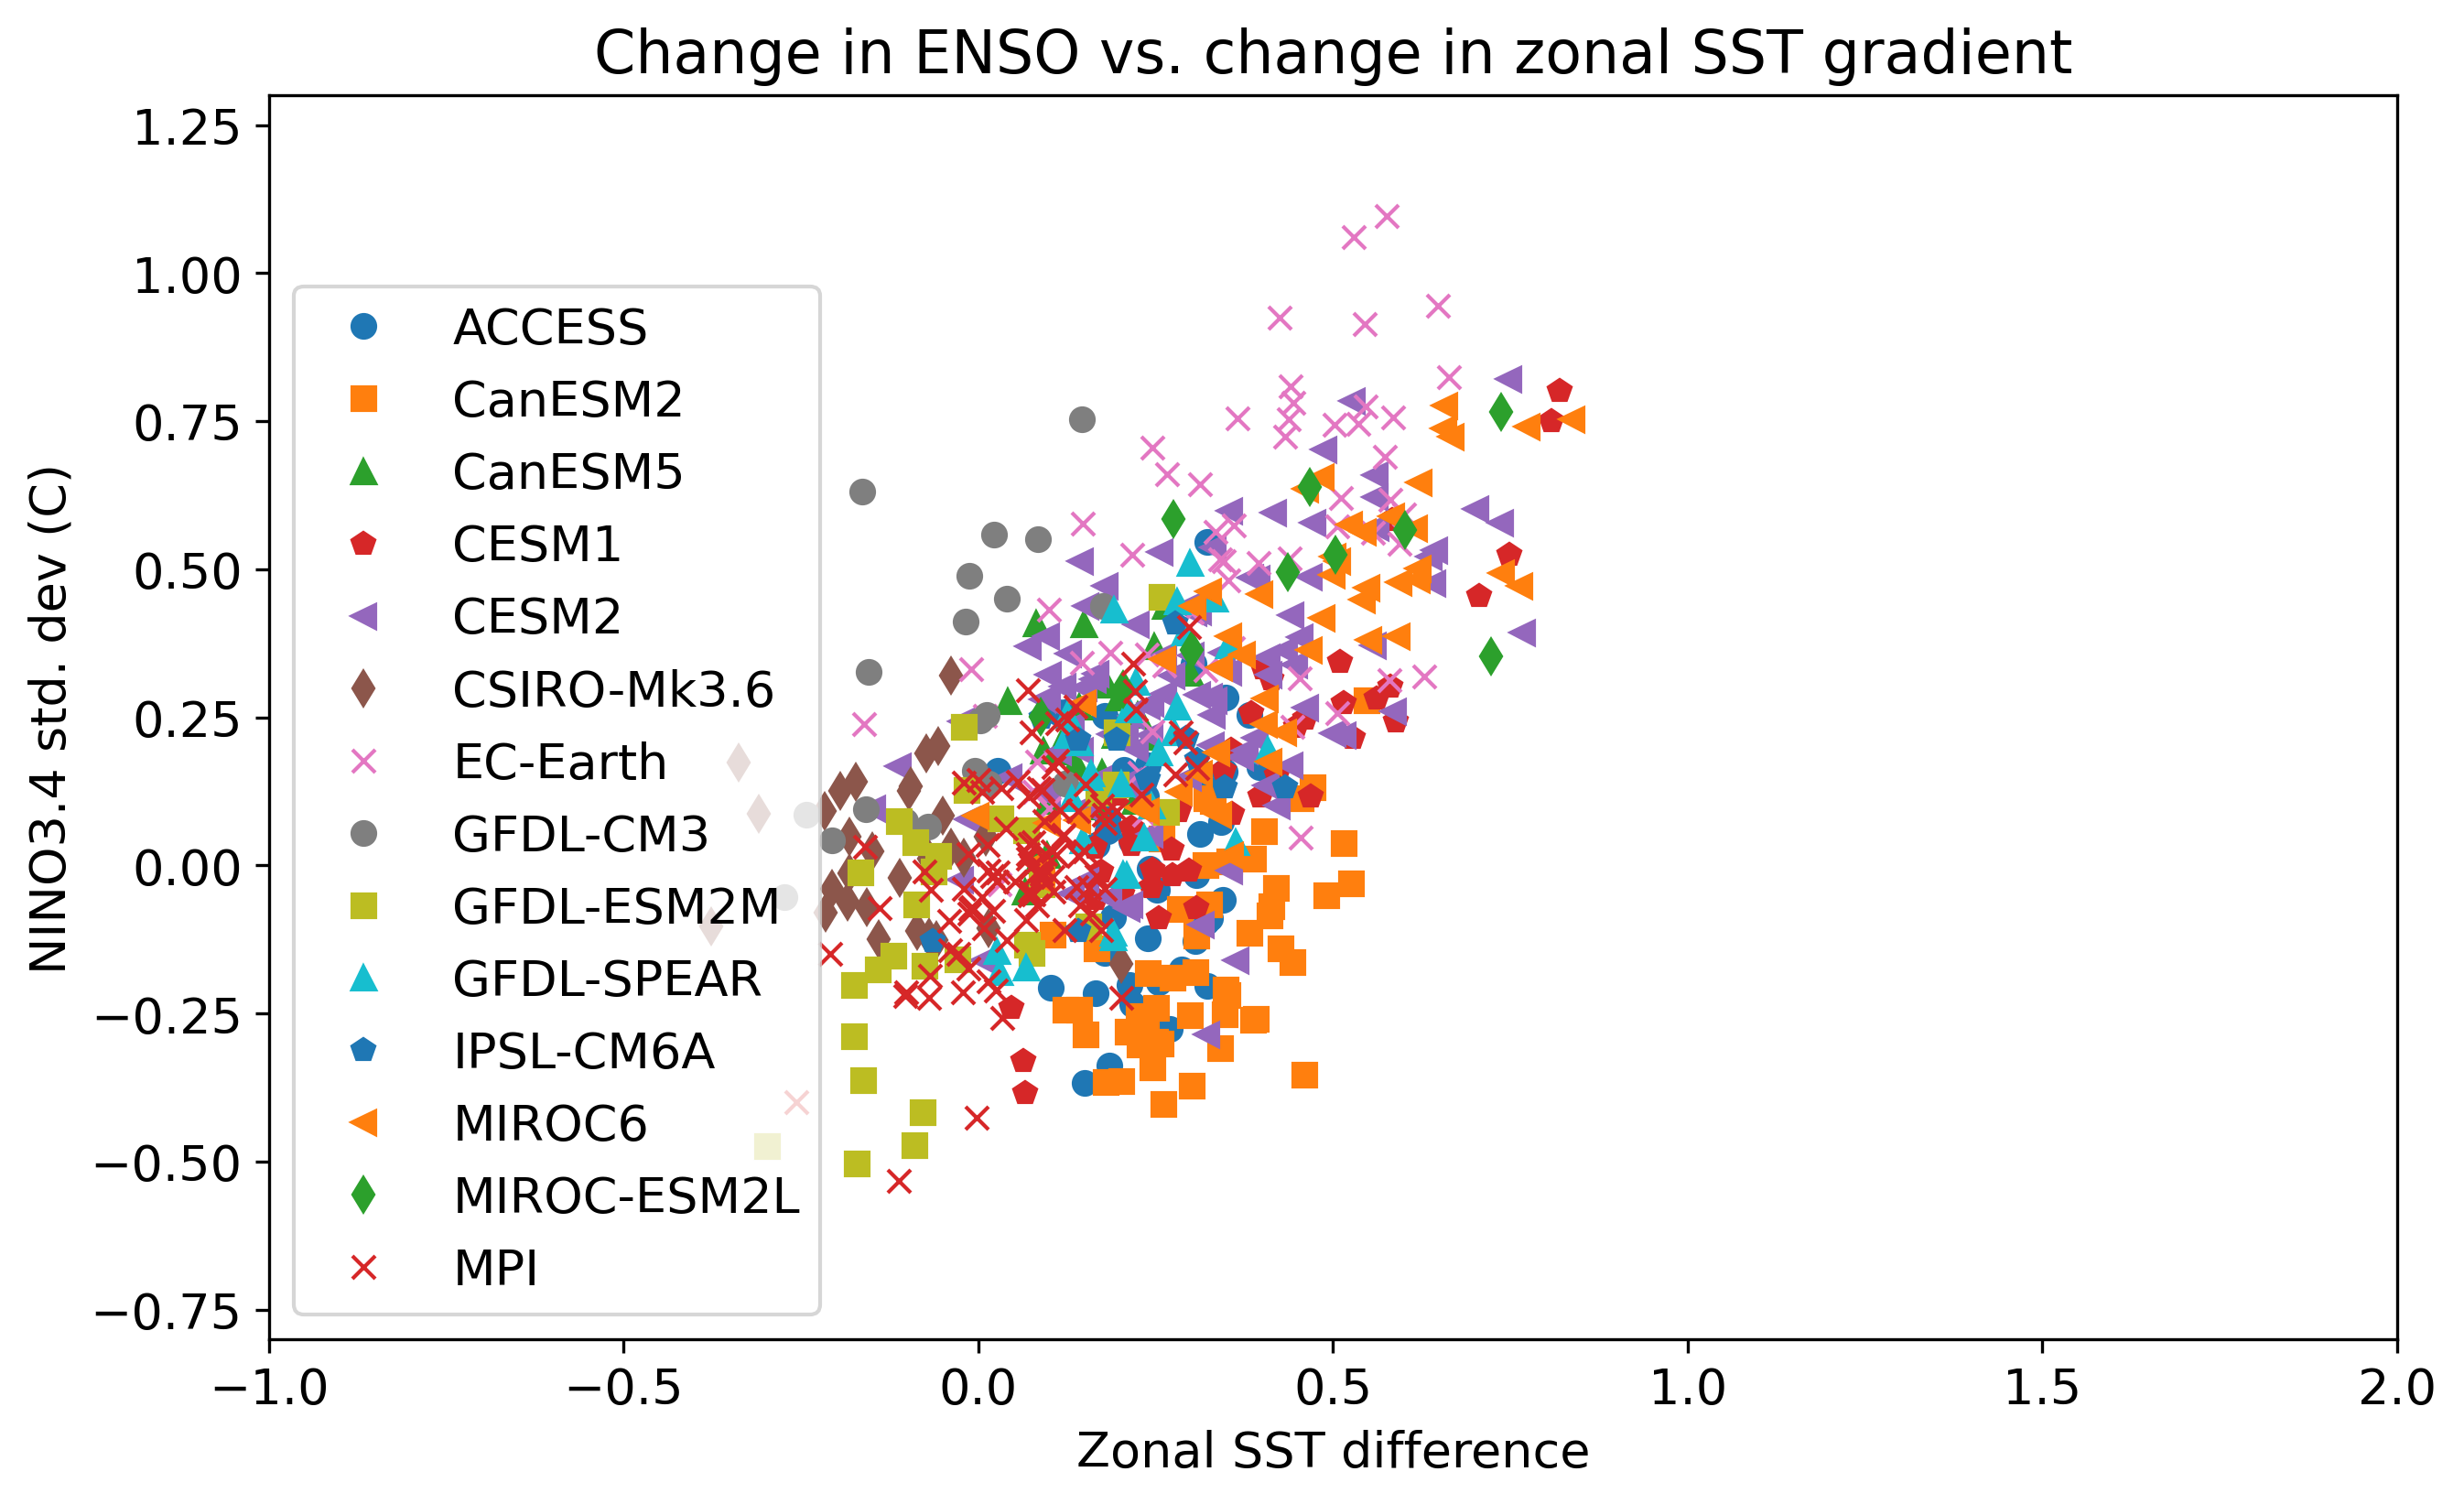

In [6]:
plt.figure(figsize=(10, 6), dpi=300)

sym=['o','s','^','p','<','d','x','o','s','^','p','<','d','x']
for m in range(len(mods)):
    ztmp=ens_zdiff_arr[m]
    ntmp=ens_n34std_arr[m]
    plt.plot(ztmp,ntmp,sym[m])
        
plt.title('Change in ENSO vs. change in zonal SST gradient')
plt.ylabel('NINO3.4 std. dev (C)')
plt.xlabel('Zonal SST difference')
plt.ylim([-0.8,1.3])
plt.xlim([-1,2])

plt.legend(modscaps,loc='lower left')

plt.savefig(plotdir+'deltaNINO34stddev_vsdeltazonalgrad_'+str(st_int[0])+'-'+str(st_int[1])+'_vs_'+str(end_int[0])+'-'+str(end_int[1])+'.pdf', format='pdf', bbox_inches='tight', dpi=300)

In [7]:
plotdir

'/glade/scratch/samantha/plots/ENSOworkshop/'